<a href="https://colab.research.google.com/github/sigvehaug/DSF-DCBP/blob/main/Fitting_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Curve Resolution + Global fitting script

#### Script to perform MCR analysis in python using numpy.

Data files: On Ilias of the course
Documentation MCR package: https://pages.nist.gov/pyMCR
Documentaiton symfit package: https://symfit.readthedocs.io/en/stable/tutorial.html

03.11.2021: Creation (Olivier Bardagot)
- Perform MCR decomposition with spectrum and/or concentration fixed
- Save the result of each MCR as txt
- Select the concentration temporal evolution for a given voltage cycling (doping/dedoping)
- Perform global fitting using i) biexponentails, ii) triexponentials, or iii) differential equations

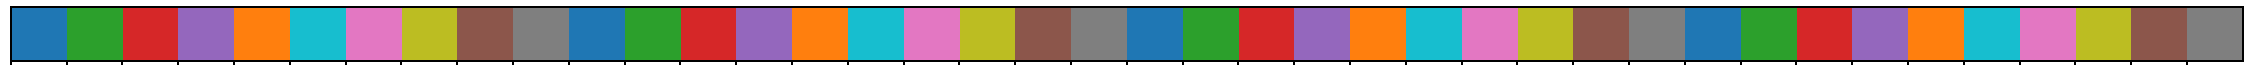

In [ ]:
# IMPORT ALL THE LIBRARIES
import numpy as np
import pandas as pd
import os
from timeit import default_timer as timer # To return the execution time of a cell (cf MCR calculation cell) 

# #Packages needed for graph plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

# Packages needed for MCR decomposition
%matplotlib inline
plt.rcParams['savefig.dpi'] = 200
from pymcr.mcr import McrAR # MCR package
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from sklearn.linear_model import Ridge

# Packages needed for global fitting using symfit
from symfit.core.minimizers import NelderMead, BFGS
from symfit import variables, Parameter, Fit, D, Model, ODEModel, Piecewise, exp, GreaterThan, Equality


style={'description_width': 'initial'}

graph_parameters = {'font.size': 11, 
    'legend.title_fontsize' : 'x-large', #Requires update of python and matplotlib 3.0
#     'figure.figsize': (4.85,3.7), # Best size for direct export in a ppt presentation
    'figure.figsize': (10,7), # Best size for direct export in a ppt presentation
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'legend.fontsize' : 19, # 15
    'axes.linewidth' : 2,
    'lines.linewidth' : 3,
    'xtick.major.width' : 2,
    'ytick.major.width' : 2,
    'lines.markersize' : 2,
    'errorbar.capsize' : 4,
    'axes.grid': False}
plt.rcParams.update(graph_parameters)

mark_=['^', 's', 'o', 'd', 'v', 'X', '<', '>']*30


color_MCR = sns.color_palette() # Color list 
myorder = [0, 2, 3, 4, 1, 9, 6, 8, 5, 7] # Redefine the color list
color_MCR = [color_MCR[i] for i in myorder]*4

sns.palplot(color_MCR) # Show the color scale

def plot_abs_layout(max_abs, step_abs):
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance (mOD)')
    if (max_abs == None):
        plt.axis('tight') # Set ideal x and y axis
#         plt.ylim(-10, None)# Fix the x axis limits
    else:
        plt.ylim(-max_abs*0.05, max_abs*1.05)# Fix the x axis limits
        plt.yticks(np.arange(0, max_abs*1.05, step=step_abs))
    plt.axhline(y=0, ls='--', lw=1, c='k') # Set a straight black line at y=0, h=horizontal
    plt.xlim(left=400, right=1450) # Fix the x axis limits by default
    plt.xticks(np.arange(400, 1450, step=200))
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.tick_params(which='minor', length=7, color='k')
    plt.tick_params(which='major', length=12, color='k')
    plt.tight_layout() # To avoid plot overlap

# Olivier's update on Gonzague's FUCNTION TO DETECT applied Vgs switch bas
def switch_time(Time, Voltage): ### Detection threshold <= steps in potential square pulse exp.
    #Make a list of the voltage switches
    index_on=[]
    index_off=[]
    skip_points = 1 ### MODIFY: to skip points after indices were found to prevent multiple ON/OFF in same cycle.
    detection_threshold = 0.04 # Volt, must be inferior to the voltage step
    n=0
    while n <= (len(Voltage)-2): ### Adapted function for Experiences with Integration > 1
        if(Voltage[n]-Voltage[n+1]) > detection_threshold:
            index_on.append(n)
            n += skip_points
        elif(Voltage[n]-Voltage[n+1]) < -detection_threshold:
            index_off.append(n)
            n += skip_points
        else:
            n += 1
            
    last_index = len(Voltage)-1 # Deal with the special case of the last point
    index_on.append(last_index)
        
    index_all=sorted(index_on + index_off)
    time_on = Time[index_on]
    time_off = Time[index_off]
    time_all = Time[index_all]
    return (time_on, time_off, time_all, index_on, index_off, index_all)


plt.show()

### Load spectral data

Averaged data successfully loaded.
Dwell ON = 350 s and dwell OFF = 350 s. 35 cycles

Wavelength from 390 to 1460 nm.
Number of curves in this data set = 42470.
Execution time = 0.082 min



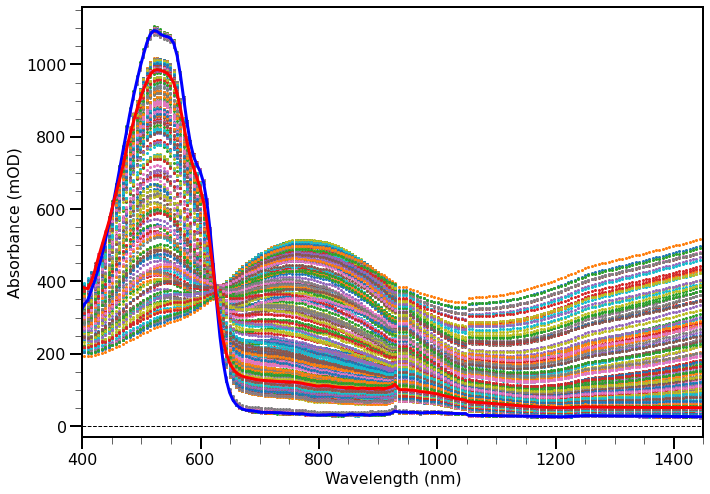

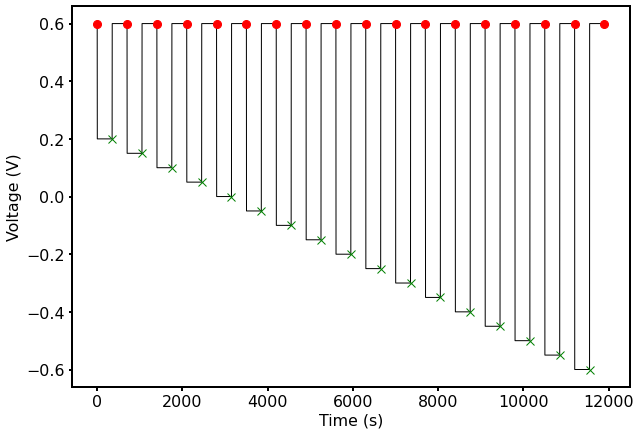

In [ ]:
#Load data for MCR using numpy
start_time=timer()

#################################### TO ADAPT ####################################
project = '/Users/olivier/Documents/Projects/'
dir_ = project + 'P3HT_project/Measurements/Flame/Teaching/'
file_name = 'P3HT_Abs_data_Teaching'

Wavelength_min = 390 # nm
Wavelength_max = 1460 # nm
###################################################################################

file_data = dir_ + file_name  + '.txt'

#Load the data as numpy dataframe (df)
df = np.loadtxt(file_data, delimiter='\t', skiprows=0) 
print('Averaged data successfully loaded.')

mskip = 100 # Skip curves to plot faster as dataset is large
Time=df[1:, 0] #4:,0 to load the 1st column while excluding the 3 first lines (wavelength, dark, ref sub, ref film)
Vgs_steps = df[1:,1]
switch=switch_time(Time, Vgs_steps)
time_on=switch[0] # List of all the switches ON times in seconds
time_off=switch[1]
time_all=switch[2]
index_on=switch[3] # List of all the switches ON indices
index_off=switch[4]
index_all=switch[5]
dwell_on=int(round(time_off[1]-time_on[1]))
dwell_off=int(round(time_on[1]-time_off[0]))
print("Dwell ON = %i s and dwell OFF = %i s. %i cycles\n" %(dwell_on, dwell_off, len(time_all)))

START=np.searchsorted(df[0,:], Wavelength_min) # find the index of the wavelenght min
END=np.searchsorted(df[0,:], Wavelength_max) # find the index of the wavelenght max   

Wavelength=df[0, START:END] # Assign the 1st line from START to END as Wavelength
print("Wavelength from %i to %i nm." %(Wavelength_min, Wavelength_max))
data=df[1:, START:END].T # Assign the 2D matrix from 2nd line to last line from START to END columns as absorbance data

plt.plot(Wavelength, data[:,0::mskip], 'o') # Plot the data loaded
plt.plot(Wavelength, data[:,0], '-b') # Highlight the first spectrum in blue
plt.plot(Wavelength, data[:,-1], '-r') # Highlight the last spectrum in red
plot_abs_layout(None, None)

print("Number of curves in this data set = %i." %len(data.T)) # %i to display the variable as an integer

exe_time = timer()-start_time
print("Execution time = %.2g min" %(exe_time/60) + "\n") # Time of calculation of this cell in min

plt.figure(2)
plt.plot(Time, Vgs_steps, '-k', lw=1)
plt.plot(time_on, Vgs_steps[index_on], 'or', ms=8, label='Time_ON')
plt.plot(time_off, Vgs_steps[index_off], 'xg', ms=8, label='Time_OFF')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
os.system('say "OK"')
plt.show()


### Load spectral decomposition from 'P3HT_Spectral_decomposition.txt' file

3 components were considered.


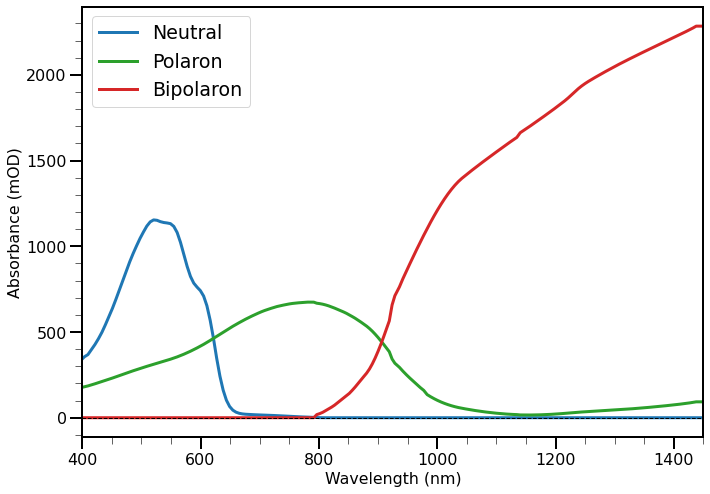

In [ ]:
df_MCR_ST=np.loadtxt(dir_ + 'P3HT_Spectral_decomposition.txt', delimiter= '\t') #Load the given spectral decomposition file

START_MCR = np.searchsorted(df_MCR_ST.T[0,:], Wavelength_min)
END_MCR = np.searchsorted(df_MCR_ST.T[0,:], Wavelength_max)

# Load x and y axis grom spectral decomposition file
Wavelength_MCR = df_MCR_ST.T[0, START_MCR:END_MCR] # Load wavelength
spectral_guess = df_MCR_ST.T[1:, START_MCR:END_MCR] # Load spectral guess

print('%i components were considered.' %len(spectral_guess))

label_specie=['Neutral', 'Polaron', 'Bipolaron']

for i in range (len(spectral_guess)):
#     plt.plot(Wavelength_MCR, spectral_guess[i], '-', c=color_MCR[i], label=label_specie[i])
    plt.plot(Wavelength, spectral_guess[i], '-', c=color_MCR[i], label=label_specie[i])
plot_abs_layout (None, None)
plt.legend(title = '' ,loc = 'best')
plt.show()


### Run MCR on spectral data (assuming a system of the form: D = C*S^T)

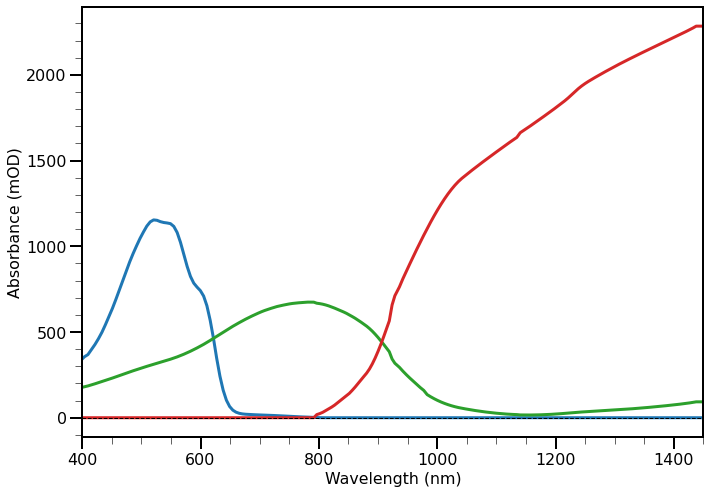

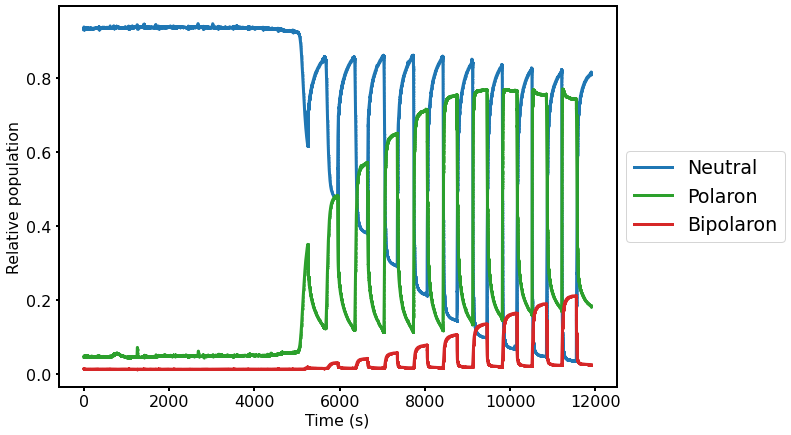

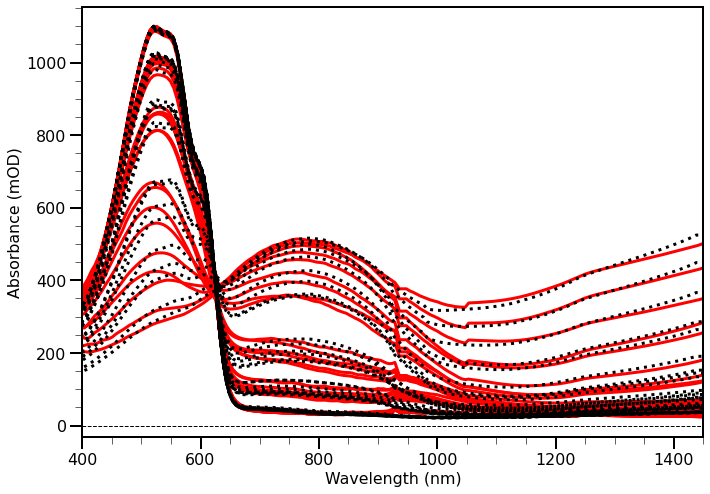

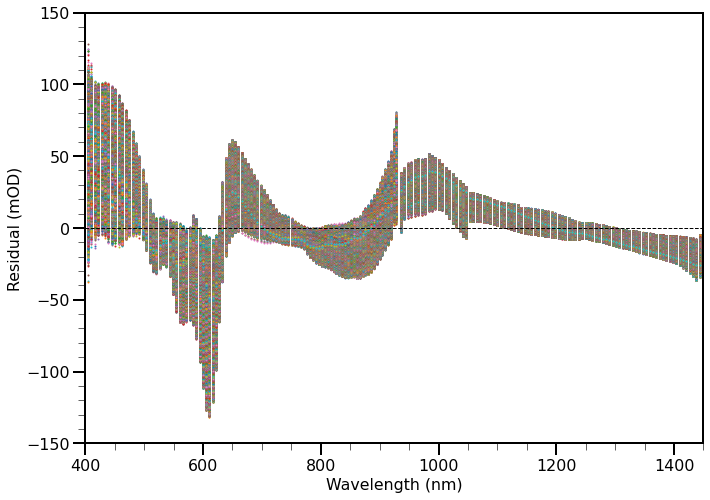

In [ ]:
######################### TO MODIFY AT WILL #########################
# Criteria for the spectra
st_regr=NNLS() # NNLS() = non-negative least squares,  or OLS() = Ordinary least squares
st_constraints=[ConstraintNonneg()] # Constraint spectra to be positive, already included in NNLS

# Criteria for the concentrations
c_regr=NNLS() 
c_constraints=[ConstraintNonneg()]

# Convergence criteria
max_iter=100
tol_increase=5
tol_n_above_min=2
tol_n_increase=3
tol_err_change=1e-10

# Fitting conditions
data_to_fit = data.T
ST = spectral_guess  # Spectral guesses
st_fix = [0,1,2]     # Lock the spectra: 0 = Neutral, 1 = Polaron, 2 = Bipolaron
c_fix=[]            # Lock the concentration: 0 = Neutral, 1 = Polaron, 2 = Bipolaron

# Skip plotting some curves to see better the fit quality
mskip = 1000 # Plot every 1000 spectra
########################################################################

# Define the MCR criteria
mcrar = McrAR(st_regr=st_regr, st_constraints=st_constraints, 
              c_regr=c_regr, c_constraints=c_constraints, 
              max_iter=max_iter, tol_increase=tol_increase, tol_n_above_min=tol_n_above_min, 
              tol_n_increase=tol_n_increase, tol_err_change=tol_err_change)

# Perform the MCR
if 'concentration_guess' in globals(): # If the variable concentration_guess exists
    mcrar.fit(data_to_fit, ST=ST, C=concentration_guess, st_fix=st_fix, c_fix=c_fix)
else: # If not, case when no concentration guesses are used = first run of the MCR
    print('No concentration guesses used')
    mcrar.fit(data_to_fit, ST=ST, st_fix=st_fix)
    
plt.figure(1)
for i in range (len(spectral_guess)):
    plt.plot(Wavelength, mcrar.ST_opt_[i].T, '-', c=color_MCR[i], label=label_specie[i])
plot_abs_layout (None, None)

plt.figure(2)
for i in range (len(spectral_guess)):
    plt.plot(Time, mcrar.C_opt_.T[i], '-'+mark_[i], ms=1, c=color_MCR[i], label=label_specie[i])
plt.ylabel('Relative population')
plt.xlabel('Time (s)')
plt.legend(title = '' ,loc = 'center left',bbox_to_anchor=(1,0.5))

# Perform D = C*S^T to reconstruct the data 
fit_data = np.dot(mcrar.ST_opt_.T, mcrar.C_opt_.T)

plt.figure(3) # Plot raw (red) and reconstructed data (black) to estimate the fit quality
plt.plot (Wavelength, data[:,0::mskip], '-r')
plt.plot (Wavelength, fit_data[:,0::mskip], ':k')
plot_abs_layout (None, None)

plt.figure(4) # Plot the MCR residuals = raw - fit_data
for i in range(len(Time)):
    residuals_MCR = data[:,i] - fit_data[:,i]
    plt.plot(Wavelength, residuals_MCR, 'o', ms=1)
plot_abs_layout (None, None)
plt.ylabel('Residual (mOD)')
plt.ylim (-150, 150)

plt.show()

### RUN this cell if you are happy with the MCR output

In [ ]:
spectral_guess = mcrar.ST_opt_.copy()  # Replace spectral_guess with the spectral MCR output
concentration_guess = mcrar.C_opt_.copy() # Replace concentration_guess with the concentration MCR output
print('MCR results approved')

MCR results approved


### Save MCR SPECTRA and CONCENTRATION as .txt

In [ ]:
specific_name = 'Final'

new_folder= dir_ + 'Analysis_' + file_name

try:
    os.makedirs(new_folder) # Create a folder
except FileExistsError:
    print(new_folder + " already exists\n")  
       
save_spectra = np.vstack((Wavelength, spectral_guess)).T
save_concentration = np.vstack((Time, concentration_guess.T)).T
    
if (os.path.exists(new_folder + '/_MCR_Spectra_'+ specific_name +'.txt') == False): # Avoid overwriting MCR data
    # Save as txt file. In Igor type Loadwave/G/A=MCR_fit to load these files.
    np.savetxt(new_folder + '/_MCR_Spectra_'+ specific_name +'.txt', save_spectra, fmt='%.12f', delimiter= '\t')
    np.savetxt(new_folder + '/_MCR_CvsVoltage_'+ specific_name +'.txt', save_concentration, fmt='%.12f', delimiter= '\t')
    print("MCR spectra and concentration version " + specific_name +  " saved!")
else:
    print("/!\ NOT SAVE -- Version " + specific_name +  " already exists -- NOT SAVE /!\ ")

/Users/olivier/Documents/Projects/P3HT_project/Measurements/Flame/Teaching/Analysis_P3HT_Abs_data_Teaching already exists

/!\ NOT SAVE -- Version Final already exists -- NOT SAVE /!\ 


### Select the dedoping cycle you want to fit

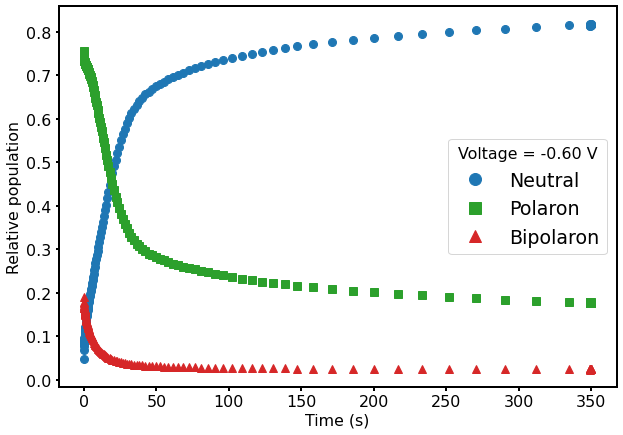

In [ ]:
# The cycle is defined above when defining the delay
####################### TO MODIFY #####################
cycle=16 # Max = 16
#######################################################

# To study dedoping
ON=index_off[cycle-1]
OFF=index_on[cycle]

# To study doping, but it is more difficult as a delay is observed
# ON=index_on[cycle-1]
# OFF=index_off[cycle-1]

Time_cycle = Time[ON:OFF]-Time[ON] # Time for the entire cycle set back to 0 to help fitting
CN = mcrar.C_opt_.T[0][ON:OFF]
CP = mcrar.C_opt_.T[1][ON:OFF]
CB = mcrar.C_opt_.T[2][ON:OFF]

plt.plot(Time_cycle, CN, 'o', ms=8, markevery=10, c=color_MCR[0], label=label_specie[0])
plt.plot(Time_cycle, CP, 's', ms=8,markevery=10, c=color_MCR[1], label=label_specie[1])
plt.plot(Time_cycle, CB, '^', ms=8, markevery=10, c=color_MCR[2], label=label_specie[2])
plt.ylabel('Relative population')
plt.xlabel('Time (s)')
plt.legend(title = 'Voltage = %.2f V' %(Vgs_steps[index_off[cycle]]), loc = 'best', markerscale=1.5)

plt.show()

### Save MCR CONCENTRATION for the ONE CYCLE you selected above as .txt

In [ ]:
save_onecycle = np.vstack((Time_cycle, CN, CP, CB)).T
    
np.savetxt(dir_ + '/' + file_name + '_'+ str(Vgs_steps[index_off[cycle]])+'V.txt',
               save_onecycle, fmt='%.12f', delimiter= '\t')

print('Cycle selection saved correctly')

Cycle selection saved correctly


### Perform GLOBAL FITTING of the concentrations of neutral, polaron, bipolaron using symfit package
#### Fit with biexponentials:  e.g.  y = A1*exp(-k1*t) + A2*exp(-k2*t) + constant

<lambdifygenerated-3855>:2: RuntimeWarning: overflow encountered in exp
  return (A1*exp(-k1*t) + A2*exp(-k2*t) - A3*exp(-k3*t) - A4*exp(-k4*t) + CP_final)
<lambdifygenerated-3854>:2: RuntimeWarning: overflow encountered in exp
  return (-A1*exp(-k1*t) - A2*exp(-k2*t) + CN_final)
/opt/anaconda3/lib/python3.8/site-packages/symfit/core/objectives.py:322: RuntimeWarning: overflow encountered in square
  (dep_var_value - dep_data) ** 2 / sigma ** 2
<lambdifygenerated-3857>:2: RuntimeWarning: overflow encountered in exp
  return (-A1*exp(-k1*t) - A2*exp(-k2*t) + CN_final)
<lambdifygenerated-3858>:2: RuntimeWarning: overflow encountered in exp
  return (A1*exp(-k1*t) + A2*exp(-k2*t) - A3*exp(-k3*t) - A4*exp(-k4*t) + CP_final)
<lambdifygenerated-3870>:2: RuntimeWarning: overflow encountered in exp
  return (-exp(-k1*t))
<lambdifygenerated-3888>:2: RuntimeWarning: overflow encountered in exp
  return (-A1*t*exp(-k1*t))
<lambdifygenerated-3877>:2: RuntimeWarning: overflow encountered in exp
  r

[B(t; A3, A4, CB_final, k3, k4) = A3*exp(-k3*t) + A4*exp(-k4*t) + CB_final,
 N(t; A1, A2, CN_final, k1, k2) = -A1*exp(-k1*t) - A2*exp(-k2*t) + CN_final,
 P(t; A1, A2, A3, A4, CP_final, k1, k2, k3, k4) = A1*exp(-k1*t) + A2*exp(-k2*t) - A3*exp(-k3*t) - A4*exp(-k4*t) + CP_final]
Execution time = 2.5 min



,A1 (a.u.),k1 (Hz),A2 (a.u.),k2 (Hz),A3 (a.u.),k3 (Hz),A4 (a.u.),k4 (Hz),CN_final (a.u.),CP_final (a.u.),CB_final (a.u.),χ$^{2}$,r$^{2}$
1,0.696965,0.039671,0.02959,5.866685,0.0833,0.379414,0.076715,0.036952,0.788997,0.189535,0.019961,0.839179,0.995231


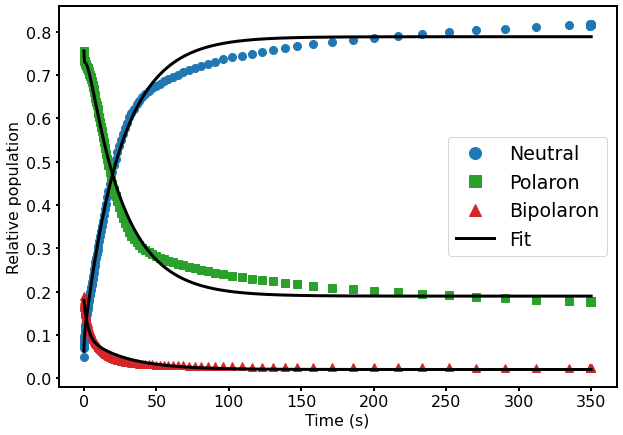

In [ ]:
start_time=timer()
# Run the fitting x (= iteration) times with random initial guesses in order to maximaze r^2
iteration = 50

best_r2 = 0
for i in range(iteration):
    # Define the initial guesses for each parameter that will be fitted
    A1_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
#     A2_guess = A1_guess*0.10  # set A2 guess as 10% of A1
    A2_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
    A3_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
#     A4_guess = A3_guess*0.2 # set A4 guess as 30% of A3
    A4_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
    k1_guess = np.random.uniform(low=0, high=2, size=1)[0] # Generate a random number between 0 and 2
#     k2_guess = k1_guess*0.1 # set k2 guess as 10% of k1
    k2_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
    k3_guess = np.random.uniform(low=0, high=2, size=1)[0] # Generate a random number between 0 and 2
#     k4_guess = k3_guess*0.01 # set k4 guess as 1% of k3
    k4_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
#     CN_final_guess = CN[-1] # Last value of CN as initial guess
#     CP_final_guess = CP[-1] 
#     CB_final_guess = CB[-1] 
    CN_final_guess = np.random.uniform(low=0.5, high=1, size=1)[0] # Generate a random number between 0.5 and 1
    CP_final_guess = np.random.uniform(low=0, high=0.3, size=1)[0] # Generate a random number between 0 and 0.3
    CB_final_guess = np.random.uniform(low=0, high=0.1, size=1)[0] # Generate a random number between 0 and 0.1

    # Define the parameters used in the fitting model
    A1 = Parameter('A1', A1_guess, min=0, max=1) # Amplitude 1st exp of CN rise
    A2 = Parameter('A2', A2_guess, min=0, max=1) # Amplitude 2nd exp of CN rise
    A3 = Parameter('A3', A3_guess, min=0, max=1) # Amplitude 1st exp of CB decay
    A4 = Parameter('A4', A4_guess, min=0, max=1) # Amplitude 2nd exp of CB decay
    k1 = Parameter('k1', k1_guess, min=0) # Rate constant 1st exp of CN rise in Hz
    k2 = Parameter('k2', k2_guess, min=0) # Rate constant 2nd exp of CN rise in Hz
    k3 = Parameter('k3', k3_guess, min=0) # Rate constant 1st exp of CB decay in Hz
    k4 = Parameter('k4', k4_guess, min=0) # Rate constant 2nd exp of CB decay in Hz
    CN_final = Parameter('CN_final', CN_final_guess, min=0, max=1) # N offset
    CP_final = Parameter('CP_final', CP_final_guess, min=0, max=1) # P offset
    CB_final = Parameter('CB_final', CB_final_guess, min=0, max=1) # B offset

    # Define the variables to fit
    t, N, P, B = variables('t, N, P, B')

    #Define constraints to help the model converging
    constraints = [GreaterThan(A1, A2), GreaterThan(A2, 0), GreaterThan(k1, k2), GreaterThan(k2, 0),
                   GreaterThan(A3, A4), GreaterThan(A4, 0), GreaterThan(k3, k4), GreaterThan(k4, 0),
                   GreaterThan(1, CN_final), GreaterThan(1, CP_final), GreaterThan(1, CB_final),
                   GreaterThan(CN_final, 0), GreaterThan(CP_final, 0), GreaterThan(CB_final, 0)]

    #Define the equations used for the global fitting
    model_dict = Model({
                        B: A3*exp(-k3*t) +  A4*exp(-k4*t) + CB_final,
                        N: - A1*exp(-k1*t) -  A2*exp(-k2*t) + CN_final,
                        P: + A1*exp(-k1*t) +  A2*exp(-k2*t) - A3*exp(-k3*t) -  A4*exp(-k4*t) + CP_final,
                        })

    #Perform the fit and print the result
    fit = Fit(model_dict, t = Time_cycle, N = CN, P = CP, B = CB
              , minimizer=[NelderMead, BFGS], constraints=constraints) # Optimised fit with constraints

    fit_result = fit.execute()
    yfit = model_dict(t = Time_cycle, **fit_result.params) 
    
    # If r^2 of this fit iteration is > to previous r^2, then save the results, else do nothing 
    if fit_result.r_squared > best_r2:
        best_fit = fit_result

print(model_dict)

# Plot the RAW DATA
plt.plot(Time_cycle, CN, 'o', ms=8, markevery=10, c=color_MCR[0], label=label_specie[0])
plt.plot(Time_cycle, CP, 's', ms=8,markevery=10, c=color_MCR[1], label=label_specie[1])
plt.plot(Time_cycle, CB, '^', ms=8, markevery=10, c=color_MCR[2], label=label_specie[2])

# Plot the FIT
plt.plot(Time_cycle, yfit[1], 'k-', label='Fit')
plt.plot(Time_cycle, yfit[2], 'k-')
plt.plot(Time_cycle, yfit[0], 'k-')
plt.ylabel('Relative population')
plt.xlabel('Time (s)')
plt.legend(title = '' ,loc = 'best', markerscale=1.5) #bbox_to_anchor=(1,0.5)
# plt.xscale('log')

exe_time = timer()-start_time
print("Execution time = %.2g min" %(exe_time/60) + "\n") # Time of calculation of this cell in min

pd.DataFrame({
    'A1 (a.u.)': best_fit.params['A1'],
    'k1 (Hz)': best_fit.params['k1'],
    'A2 (a.u.)': best_fit.params['A2'],
    'k2 (Hz)': best_fit.params['k2'],
    'A3 (a.u.)': best_fit.params['A3'],
    'k3 (Hz)': best_fit.params['k3'],
    'A4 (a.u.)': best_fit.params['A4'],
    'k4 (Hz)': best_fit.params['k4'],
    'CN_final (a.u.)' : best_fit.params['CN_final'],
    'CP_final (a.u.)' : best_fit.params['CP_final'],
    'CB_final (a.u.)' : best_fit.params['CB_final'],
    'χ$^{2}$': best_fit.chi_squared,
    'r$^{2}$': best_fit.r_squared}, 
    index=[1])


### Perform GLOBAL FITTING of the concentrations of neutral, polaron, bipolaron using symfit package
#### Fit with triexponentials:  e.g. y = A1*exp(-k1*t) + A2*exp(-k2*t) + A3*exp(-k3*t) + constant

[B(t; A4, A5, A6, CB_final, k4, k5, k6) = A4*exp(-k4*t) + A5*exp(-k5*t) + A6*exp(-k6*t) + CB_final,
 N(t; A1, A2, A3, CN_final, k1, k2, k3) = -A1*exp(-k1*t) - A2*exp(-k2*t) - A3*exp(-k3*t) + CN_final,
 P(t; A1, A2, A3, A4, A5, A6, CP_final, k1, k2, k3, k4, k5, k6) = A1*exp(-k1*t) + A2*exp(-k2*t) + A3*exp(-k3*t) - A4*exp(-k4*t) - A5*exp(-k5*t) - A6*exp(-k6*t) + CP_final]
Execution time = 2.6 min



,A1 (a.u.),k1 (Hz),A2 (a.u.),k2 (Hz),A3 (a.u.),k3 (Hz),A4 (a.u.),k4 (Hz),A5 (a.u.),k5 (Hz),A6 (a.u.),k6 (Hz),CN_final (a.u.),CP_final (a.u.),CB_final (a.u.),χ$^{2}$,r$^{2}$
1,74.533762,0.093742,-73.977378,0.094181,0.173607,0.006895,-30.465579,0.372251,30.558879,0.371603,0.057855,0.024181,0.825118,0.15493,0.018444,0.16816,0.999044


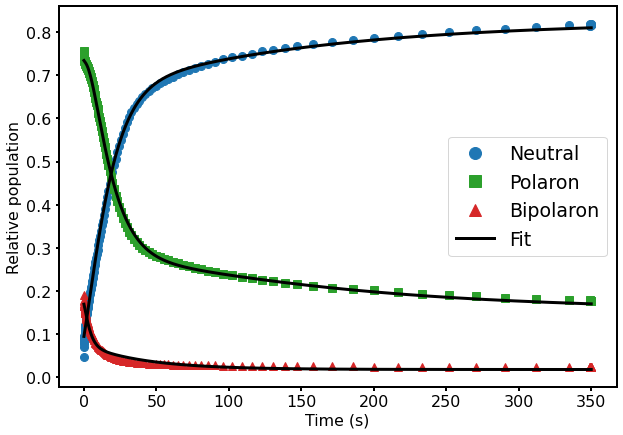

In [ ]:
start_time=timer()
# Run the fitting x (= iteration) times with random initial guesses in order to maximaze r^2
iteration = 10

best_r2 = 0
for i in range(iteration):
    # Define the initial guesses for each parameter that will be fitted
    A1_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
    A2_guess = A1_guess*0.15  # set A2 guess as 15% of A1
    A3_guess = A1_guess*0.05  # set A3 guess as 5% of A1
    A4_guess = np.random.uniform(low=0, high=1, size=1)[0] # Generate a random number between 0 and 1
    A5_guess = A4_guess*0.15  # set A5 guess as 15% of A4
    A6_guess = A4_guess*0.05  # set A6 guess as 5% of A4
    k1_guess = np.random.uniform(low=0, high=2, size=1)[0] # Generate a random number between 0 and 2
    k2_guess = k1_guess*0.2
    k3_guess = k1_guess*0.02
    k4_guess = np.random.uniform(low=0, high=2, size=1)[0] # Generate a random number between 0 and 2
    k5_guess = k4_guess*0.05
    k6_guess = k4_guess*0.005
    CN_final_guess = CN[-1] # Last value of CN as initial guess
    CP_final_guess = CP[-1] 
    CB_final_guess = CB[-1] 

    # Define the parameters used in the fitting model
    A1 = Parameter('A1', A1_guess, min=0, max=1) # Amplitude 1st exp of CN rise
    A2 = Parameter('A2', A2_guess, min=0, max=1) # Amplitude 2nd exp of CN rise
    A3 = Parameter('A3', A3_guess, min=0, max=1) # Amplitude 3rd exp of CN rise
    A4 = Parameter('A4', A4_guess, min=0, max=1) # Amplitude 1st exp of CB decay
    A5 = Parameter('A5', A5_guess, min=0, max=1) # Amplitude 2nd exp of CB decay
    A6 = Parameter('A6', A6_guess, min=0, max=1) # Amplitude 3rd exp of CB decay
    k1 = Parameter('k1', k1_guess, min=0) # Rate constant 1st exp of CN rise in Hz
    k2 = Parameter('k2', k2_guess, min=0) # Rate constant 2nd exp of CN rise in Hz
    k3 = Parameter('k3', k3_guess, min=0) # Rate constant 3rd exp of CN rise in Hz
    k4 = Parameter('k4', k4_guess, min=0) # Rate constant 1st exp of CB decay in Hz
    k5 = Parameter('k5', k5_guess, min=0) # Rate constant 2nd exp of CB decay in Hz
    k6 = Parameter('k6', k6_guess, min=0) # Rate constant 3rd exp of CB decay in Hz
    CN_final = Parameter('CN_final', CN_final_guess, min=0, max=1) # N offset
    CP_final = Parameter('CP_final', CP_final_guess, min=0, max=1) # P offset
    CB_final = Parameter('CB_final', CB_final_guess, min=0, max=1) # B offset


    # Define the variables to fit
    t, N, P, B = variables('t, N, P, B')

    #Define constraints to help the model converging
    constraints = [GreaterThan(A1, A2), GreaterThan(A2, A3), GreaterThan(A3, 0), GreaterThan(k1, k2), GreaterThan(k2, k3), GreaterThan(k3, 0),
           GreaterThan(A4, A5), GreaterThan(A5, A6), GreaterThan(A6, 0), GreaterThan(k4, k5), GreaterThan(k5, k6), GreaterThan(k6, 0)] 

    #Define the equations used for the global fitting
    model_dict = Model({       
        B: A4*exp(-k4*t) + A5*exp(-k5*t) +  A6*exp(-k6*t) + CB_final,
        N: - A1*exp(-k1*t) -  A2*exp(-k2*t) -  A3*exp(-k3*t) + CN_final,
        P: + A1*exp(-k1*t) +  A2*exp(-k2*t) + A3*exp(-k3*t) -  A4*exp(-k4*t) - A5*exp(-k5*t) -  A6*exp(-k6*t) + CP_final,
        })

    #Perform the fit and print the result
    fit = Fit(model_dict, t = Time_cycle, N = CN, P = CP, B = CB
      ,minimizer=[NelderMead, BFGS], constraints=constraints) # Optimised fit with constraints
    fit_result = fit.execute()
    yfit = model_dict(t = Time_cycle, **fit_result.params) 
    
    # If r^2 of this fit iteration is > to previous r^2, then save the results, else do nothing 
    if fit_result.r_squared > best_r2: 
        best_fit = fit_result
        
print(model_dict)
# Plot the RAW DATA
plt.plot(Time_cycle, CN, 'o', ms=8, markevery=10, c=color_MCR[0], label=label_specie[0])
plt.plot(Time_cycle, CP, 's', ms=8,markevery=10, c=color_MCR[1], label=label_specie[1])
plt.plot(Time_cycle, CB, '^', ms=8, markevery=10, c=color_MCR[2], label=label_specie[2])

# Plot the FIT
plt.plot(Time_cycle, yfit[1], 'k-', label='Fit')
plt.plot(Time_cycle, yfit[2], 'k-')
plt.plot(Time_cycle, yfit[0], 'k-')
plt.ylabel('Relative population')
plt.xlabel('Time (s)')
plt.legend(title = '' ,loc = 'best', markerscale=1.5)
# plt.xscale('log')

exe_time = timer()-start_time
print("Execution time = %.2g min" %(exe_time/60) + "\n") # Time of calculation of this cell in min

pd.DataFrame({
    'A1 (a.u.)': best_fit.params['A1'],
    'k1 (Hz)': best_fit.params['k1'],
    'A2 (a.u.)': best_fit.params['A2'],
    'k2 (Hz)': best_fit.params['k2'],
    'A3 (a.u.)': best_fit.params['A3'],
    'k3 (Hz)': best_fit.params['k3'],
    'A4 (a.u.)': best_fit.params['A4'],
    'k4 (Hz)': best_fit.params['k4'],
    'A5 (a.u.)': best_fit.params['A5'],
    'k5 (Hz)': best_fit.params['k5'],
    'A6 (a.u.)': best_fit.params['A6'],
    'k6 (Hz)': best_fit.params['k6'],
    'CN_final (a.u.)' : best_fit.params['CN_final'],
    'CP_final (a.u.)' : best_fit.params['CP_final'],
    'CB_final (a.u.)' : best_fit.params['CB_final'],
    'χ$^{2}$': best_fit.chi_squared,
    'r$^{2}$': best_fit.r_squared}, 
    index=[1])


### Perform kinetic GLOBAL FITTING of the concentrations of neutral, polaron, bipolaron using symfit package
#### Fit with ordinary differential equations (ODEs): e.g. d[N]/dt = k*[P]^2 - (k/Keq)*[N]^2 
#### NB: Note that second-order equations are required to model doping kinetics of P3HT polymer, while first-order equations can be used for PEDOT:PSS (cf https://doi.org/10.1002/adfm.202105821)

Derivative(B, time; Keq_PN, k_bp, k_pn) = -k_bp*B**2
Derivative(N, time; Keq_PN, k_bp, k_pn) = k_pn*P**2 - k_pn*N**2/Keq_PN
Derivative(P, time; Keq_PN, k_bp, k_pn) = k_bp*B**2 - k_pn*P**2 + k_pn*N**2/Keq_PN


/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/lib/python3.8/site-packages/symfit/core/objectives.py:322: RuntimeWarning: overflow encountered in square
  (dep_var_value - dep_data) ** 2 / sigma ** 2
/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


,k_bp (Hz),k_pn (Hz),Keq_PN,χ$^{2}$,r$^{2}$
1,0.78005,0.060281,18.115082,1.329117,0.992446


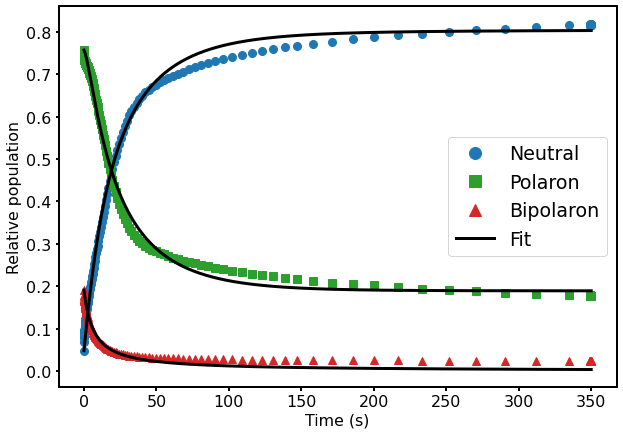

In [ ]:
# Define the parameters used in the fitting model
k_bp, k_pn, Keq_PN = parameters('k_bp, k_pn, Keq_PN')

# Define the variables to fit
time, N, P, B = variables('time, N, P, B')

model_dict = {
              D(N, time): k_pn*P**2 - (k_pn/Keq_PN)*N**2,
              D(P, time): k_bp*B**2 - k_pn*P**2 + (k_pn/Keq_PN)*N**2,
              D(B, time): -k_bp*B**2 
              }

#Define initial concentrations
initial={
      time: Time_cycle[0], 
      N: CN[0], 
      P: CP[0], 
      B: CB[0]
      }

model = ODEModel(model_dict,initial)

print(model)

#define initial guesses
data = model(
            time = Time_cycle, 
            k_bp = np.random.rand(1)[0], 
            k_pn = np.random.rand(1)[0],
            Keq_PN = np.random.rand(1)[0]
            )._asdict()
    
#Perform the fit and print the result
fit = Fit(model, time = Time_cycle, N = CN, P = CP, B = CB)
fit_result = fit.execute()
yfit = model(time = Time_cycle, **fit_result.params) 
    
# Plot the RAW DATA
plt.plot(Time_cycle, CN, 'o', ms=8, markevery=10, c=color_MCR[0], label=label_specie[0])
plt.plot(Time_cycle, CP, 's', ms=8,markevery=10, c=color_MCR[1], label=label_specie[1])
plt.plot(Time_cycle, CB, '^', ms=8, markevery=10, c=color_MCR[2], label=label_specie[2])

# Plot the FIT
plt.plot(Time_cycle, yfit[1], 'k-', label='Fit')
plt.plot(Time_cycle, yfit[2], 'k-')
plt.plot(Time_cycle, yfit[0], 'k-')
plt.ylabel('Relative population')
plt.xlabel('Time (s)')
plt.legend(title = '' ,loc = 'best', markerscale=1.5)
# plt.xscale('log')

pd.DataFrame({
    'k_bp (Hz)': fit_result.params['k_bp'],
    'k_pn (Hz)': fit_result.params['k_pn'],
    'Keq_PN': fit_result.params['Keq_PN'],
    'χ$^{2}$': fit_result.chi_squared,
    'r$^{2}$': fit_result.r_squared}, 
    index=[1])